# Forecast Police Service Calls

***

## Libraries

In [3]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
#import plotly.express as px
#!pip install --disable-pip-version-check -q seaborn==0.11.0
#import seaborn as sns
import datetime
#%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker.estimator import Estimator
from sagemaker.analytics import HyperparameterTuningJobAnalytics

np.random.seed(1)

In [64]:
# Run this cell to import the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

import sagemaker_datawrangler

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

***

## Variables - Setup

In [4]:
prefix = "Forecasting/Calls"

db_name = "sdpd"
bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

sagemaker_session = sagemaker.Session()
role = get_execution_role()
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

s3 = boto3.client("s3")
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

Data_length = 1000
prediction_length = 48
context_length = 480


***

## Functions

In [5]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [6]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding=encoding,
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

***

## Retrive Data

In [7]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'calls_hour'
)

print(Stops_Hourly)

SELECT * FROM sdpd.calls_hour
    order by date_time desc
     LIMIT 1000
     


In [8]:
calls = pd.read_sql(Stops_Hourly, conn)
calls['count'] = calls['count'].astype(int)
calls = calls.sort_values(by='date_time', ascending=True)
calls['timestamp'] = pd.to_datetime(calls.date_time).dt.tz_localize(None)
#calls['date_time'] = calls['date_time'].isoformat()
calls.head(5)

,date_time,count,year,hour,timestamp
999,2023-02-17 08:00:00+00:00,74,2023,8,2023-02-17 08:00:00
998,2023-02-17 09:00:00+00:00,68,2023,9,2023-02-17 09:00:00
997,2023-02-17 10:00:00+00:00,57,2023,10,2023-02-17 10:00:00
996,2023-02-17 11:00:00+00:00,76,2023,11,2023-02-17 11:00:00
995,2023-02-17 12:00:00+00:00,93,2023,12,2023-02-17 12:00:00


In [9]:
call_data= calls['count'].values

In [10]:
#last_row = calls.iloc[-1:]
first_row = calls.iloc[:1]
#first_date = last_row['timestamp']
first_date = first_row['timestamp']
first_date =pd.to_datetime(first_date)
#first_date = first_row['timestamp']
#first_timestamp = first_date.iloc[0].to_pydatetime()
data_length = calls.shape[0]
freq='H'

In [11]:
print(first_date[Data_length-1])

2023-02-17 08:00:00


In [12]:
time_series_calls =[]
index = pd.date_range(start=first_date[Data_length-1], freq=freq, periods=data_length)
time_series_calls.append(pd.Series(data=call_data , index=index))

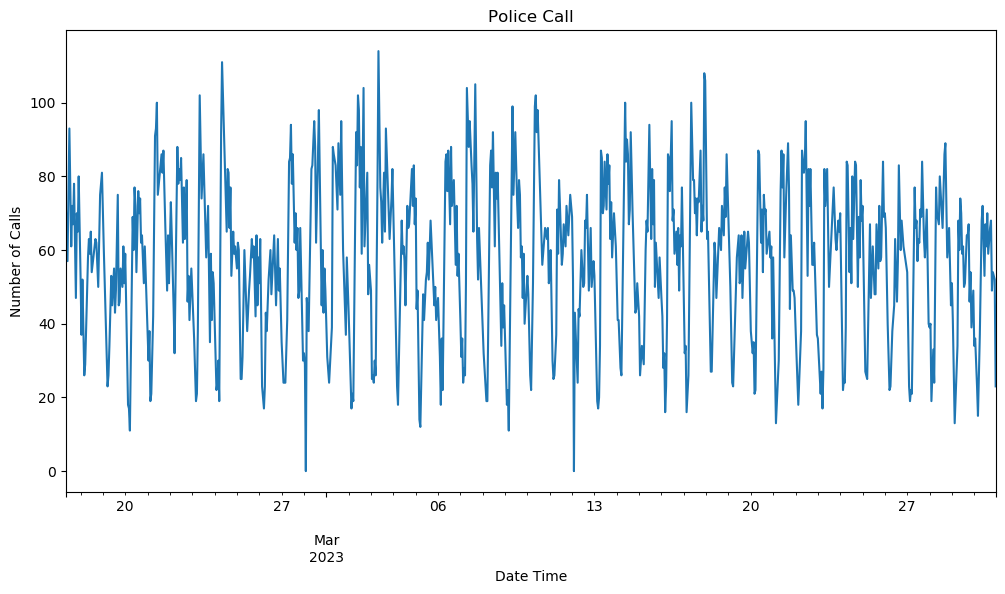

In [76]:
plt.figure(figsize=(12, 6))
plt.style.use('fast')
time_series_calls[0].plot()
plt.title("Police Call")
plt.ylabel('Number of Calls')
plt.xlabel('Date Time')
plt.show()

***

## Spliy Train and Test

In [15]:
time_series_training = []
for ts in time_series_calls:
    time_series_training.append(ts[:-prediction_length])

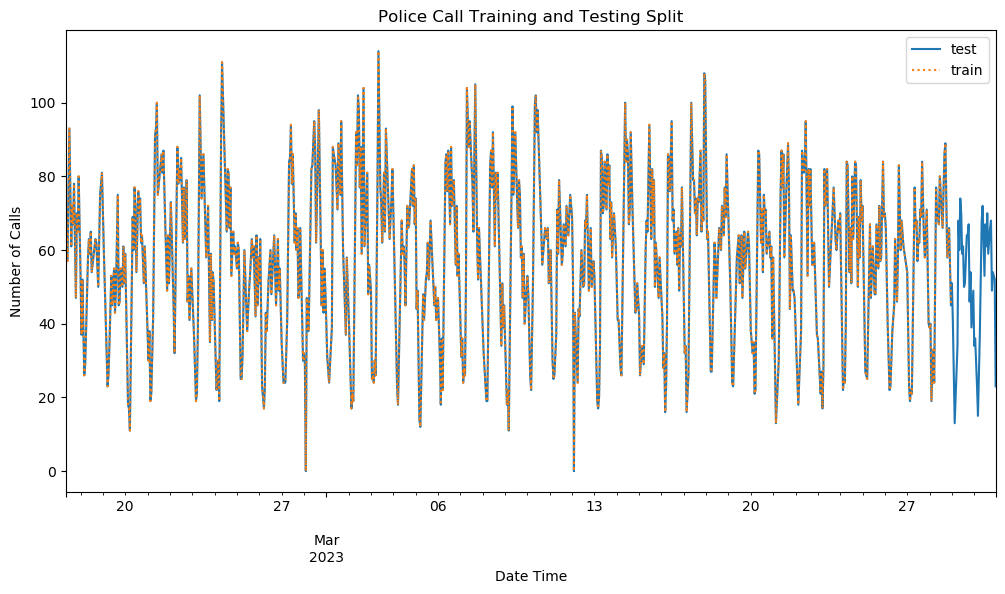

In [77]:
plt.figure(figsize=(12, 6))
time_series_calls[0].plot(label="test")
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.title("Police Call Training and Testing Split")
plt.ylabel('Number of Calls')
plt.xlabel('Date Time')
plt.show()

***

## Upload Train and Test data as JSON

In [17]:
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in time_series_calls:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
        

s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

***

## Train Model

# Create the estimator object
estimator = Estimator(
                    sagemaker_session=sagemaker_session,
                    image_uri=image_uri,
                    role=role,
                    instance_count=1,
                    instance_type="ml.c5.xlarge",
                    base_job_name="SDPD-Calls",
                    output_path=f"s3://{s3_output_path}",
                   hyperparameters=hyperparameters,
                    metric_definitions=[
                        {'Name': 'train:accuracy', 'Regex': 'Accuracy=(.*?);'},
                        {'Name': 'train:loss', 'Regex': 'Loss=(.*?);'}
                    ]
)

In [19]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    base_job_name="SDPD-Calls",
    output_path=f"s3://{s3_output_path}",
)

In [20]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "test:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "test:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

In [21]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "student-T",
    "epochs": "50",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "30",
}

In [22]:
# Set accuracy and loss as the metrics to optimize for during training
#estimator.set_metric_definitions([
  #  {'Name': 'train:accuracy', 'Regex': 'accuracy=(.*?);'},
    #{"Name": "test:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    #{'Name': 'train:loss', 'Regex': 'loss=(.*?);'}
#])

In [23]:
estimator.set_hyperparameters(**hyperparameters)

In [24]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: SDPD-Calls-2023-04-07-02-40-54-258


2023-04-07 02:40:59 Starting - Starting the training job...
2023-04-07 02:41:14 Starting - Preparing the instances for training......
2023-04-07 02:42:31 Downloading - Downloading input data
2023-04-07 02:42:31 Training - Downloading the training image......
2023-04-07 02:43:16 Training - Training image download completed. Training in progress.Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[04/07/2023 02:43:20 INFO 139937952556864] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'au

***

## Model Metrics

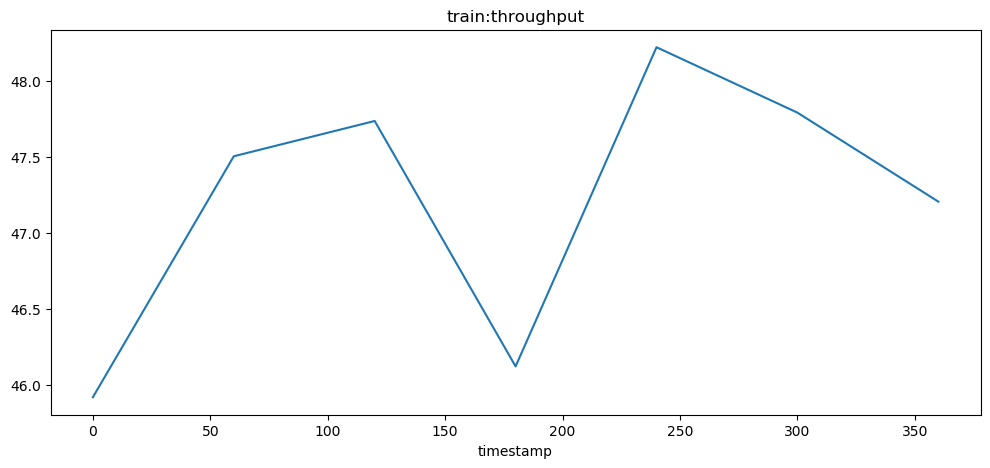

In [79]:
training_job_name = estimator.latest_training_job.name
metric_name = 'train:throughput'
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe.plot(kind='line',
                       figsize=(12,5),
                       x='timestamp',
                       y='value', 
                       #style='b.', 
                       legend=False)
plt.title(metric_name)
plt.show()

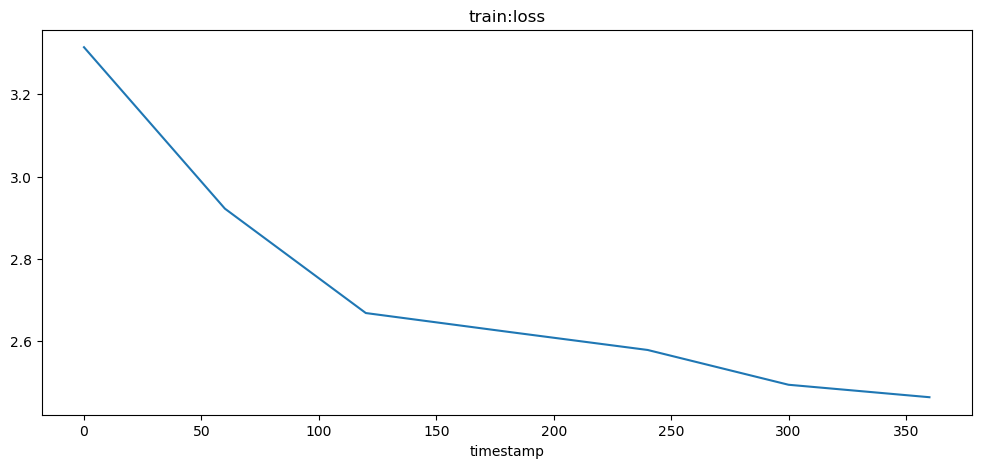

In [78]:
training_job_name = estimator.latest_training_job.name
metric_name = 'train:loss'
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe.plot(kind='line',
                       figsize=(12,5),
                       x='timestamp',
                       y='value', 
                       #style='b.', 
                       legend=False)
plt.title(metric_name)
plt.show()

In [27]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:mean_wQuantileLoss'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.137042


In [28]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:RMSE'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:RMSE,10.681842


In [29]:
job_analytics_data = estimator.training_job_analytics
analytics = job_analytics_data.dataframe()
analytics

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.137042
1,0.0,train:loss:batch,3.638900
2,60.0,train:loss:batch,2.887325
3,120.0,train:loss:batch,2.650801
4,180.0,train:loss:batch,2.610300
5,240.0,train:loss:batch,2.524416
6,300.0,train:loss:batch,2.516965
7,360.0,train:loss:batch,2.321760
8,0.0,train:progress,5.000000
9,60.0,train:progress,17.000000


In [30]:
job_name = estimator.latest_training_job.name
analytics = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=job_name
)['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(analytics))

Training job RMSE: 10.681842803955078


In [31]:
client = boto3.client('sagemaker')
description = client.describe_training_job(TrainingJobName=job_name)

In [32]:
# retrieve the RMSE metric from the training job description
rmse = description['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(rmse))

Training job RMSE: 10.681842803955078


***

## Endpoint 

In [33]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: SDPD-Calls-2023-04-07-02-40-54-258
INFO:sagemaker:Creating endpoint-config with name SDPD-Calls-2023-04-07-02-40-54-258
INFO:sagemaker:Creating endpoint with name SDPD-Calls-2023-04-07-02-40-54-258


---------!

***

## Forecast

In [34]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [35]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series_calls[:5]

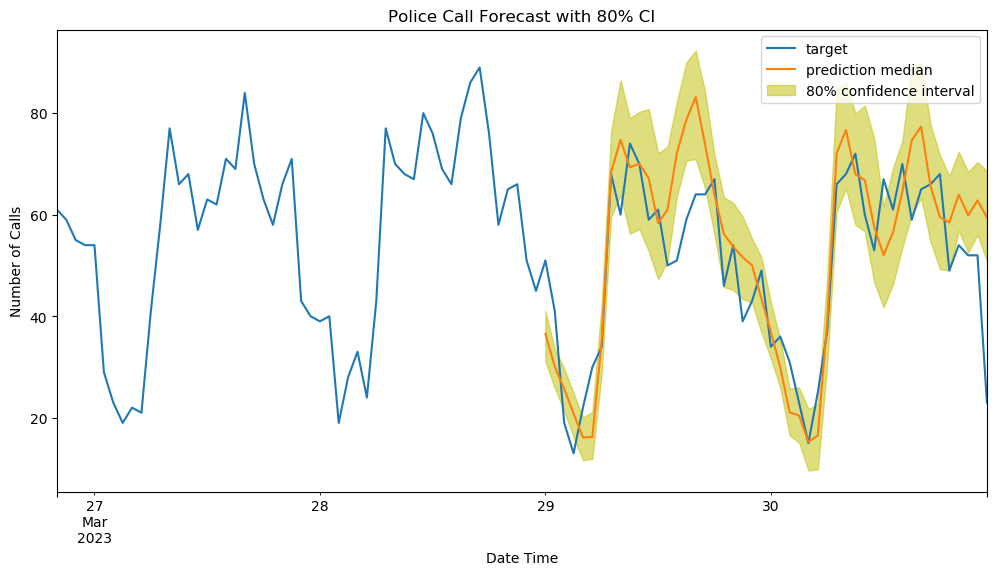

In [75]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-100:].plot(label="target")
    #actual_data[-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.title("Police Call Forecast with 80% CI")
    plt.ylabel('Number of Calls')
    plt.xlabel('Date Time')
    plt.show()

In [69]:
-prediction_length - context_length

-528

In [38]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: SDPD-Calls-2023-04-07-02-40-54-258


***

## Hyperparameter Tunning

In [49]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

tuner = HyperparameterTuner(
    estimator,
    objective_type='Minimize',
    objective_metric_name='test:RMSE',
    hyperparameter_ranges={
                                                'dropout_rate': sagemaker.tuner.ContinuousParameter(0.2, 0.4),
                                                'likelihood': sagemaker.tuner.CategoricalParameter(['student-t', 'gaussian']),
                                                'context_length': sagemaker.tuner.IntegerParameter(30, 60),
                                                'embedding_dimension': sagemaker.tuner.IntegerParameter(10, 20),
                                                'num_layers': sagemaker.tuner.IntegerParameter(1, 2),
                                                'learning_rate': sagemaker.tuner.ContinuousParameter(0.001, 0.01),
                                                'epochs': sagemaker.tuner.IntegerParameter(50, 100),
                                                'num_cells': sagemaker.tuner.IntegerParameter(64, 128),
                                                'mini_batch_size': sagemaker.tuner.IntegerParameter(32,64)
                                            },
    max_jobs=20,
    max_parallel_jobs=2,
    strategy='Bayesian'
)

In [50]:
#[dropout_rate, likelihood, context_length, embedding_dimension, num_layers, learning_rate, epochs, num_cells, mini_batch_size]

In [ ]:
tuner.fit(inputs=data_channels)

INFO:sagemaker:Creating hyperparameter tuning job with name: forecasting-deepar-230407-0259


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [58]:
from pprint import pprint

tuning_job_name = tuner.latest_tuning_job.job_name

In [59]:
tuning_job_name

'forecasting-deepar-230407-0259'

In [60]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/{}">Hyper-Parameter Tuning Job</a></b>'.format(
            region, tuning_job_name
        )
    )
)

In [61]:
hp_results = HyperparameterTuningJobAnalytics(sagemaker_session=sagemaker_session,
                                              hyperparameter_tuning_job_name=tuning_job_name)

df_results = hp_results.dataframe()
df_results.shape

(20, 15)

In [81]:
df_results.sort_values("FinalObjectiveValue", ascending=1).head(5)

INFO:root:{"event_type": "ganymede.initialization", "event_status": "start", "app_context": {"ganymede_version": "0.3.9", "app_metadata": {"AppType": "KernelGateway", "DomainId": "d-obclqmrbezxe", "UserProfileName": "police-act-user", "ResourceArn": "arn:aws:sagemaker:us-east-1:109424293498:app/d-obclqmrbezxe/police-act-user/KernelGateway/datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "ResourceName": "datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "AppImageVersion": "", "Region": "us-east-1", "AccountId": "109424293498"}}}
INFO:root:DataFrame size: row_count = 5, column_count = 15.
INFO:root:Computing on the top 10000 rows of the DataFrame.
INFO:root:Toggled to the sagemaker_datawrangler view.


    context_length  dropout_rate  embedding_dimension  epochs  learning_rate  \
1             60.0      0.378594                 10.0    54.0       0.010000   
0             51.0      0.232314                 19.0    58.0       0.004728   
15            51.0      0.231990                 10.0    55.0       0.009735   
4             51.0      0.389383                 13.0    84.0       0.007931   
8             51.0      0.270970                 10.0    56.0       0.010000   

   likelihood  mini_batch_size  num_cells  num_layers  \
1   student-t             62.0       64.0         1.0   
0   student-t             64.0       64.0         2.0   
15  student-t             56.0       71.0         1.0   
4   student-t             63.0      100.0         2.0   
8   student-t             46.0       64.0         1.0   

                                TrainingJobName TrainingJobStatus  \
1   forecasting-deepar-230407-0259-019-666e1311         Completed   
0   forecasting-deepar-230407-0259-020

INFO:root:{"event_type": "ganymede.initialization", "event_status": "success", "app_context": {"ganymede_version": "0.3.9", "app_metadata": {"AppType": "KernelGateway", "DomainId": "d-obclqmrbezxe", "UserProfileName": "police-act-user", "ResourceArn": "arn:aws:sagemaker:us-east-1:109424293498:app/d-obclqmrbezxe/police-act-user/KernelGateway/datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "ResourceName": "datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "AppImageVersion": "", "Region": "us-east-1", "AccountId": "109424293498"}}, "metadata": {"latency": 0.12116527557373047}}


In [82]:
df_results.sort_values("FinalObjectiveValue", ascending=1).head(1)

INFO:root:{"event_type": "ganymede.initialization", "event_status": "start", "app_context": {"ganymede_version": "0.3.9", "app_metadata": {"AppType": "KernelGateway", "DomainId": "d-obclqmrbezxe", "UserProfileName": "police-act-user", "ResourceArn": "arn:aws:sagemaker:us-east-1:109424293498:app/d-obclqmrbezxe/police-act-user/KernelGateway/datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "ResourceName": "datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "AppImageVersion": "", "Region": "us-east-1", "AccountId": "109424293498"}}}
INFO:root:DataFrame size: row_count = 1, column_count = 15.
INFO:root:Computing on the top 10000 rows of the DataFrame.
INFO:root:Toggled to the sagemaker_datawrangler view.


   context_length  dropout_rate  embedding_dimension  epochs  learning_rate  \
1            60.0      0.378594                 10.0    54.0           0.01   

  likelihood  mini_batch_size  num_cells  num_layers  \
1  student-t             62.0       64.0         1.0   

                               TrainingJobName TrainingJobStatus  \
1  forecasting-deepar-230407-0259-019-666e1311         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
1             9.160786 2023-04-07 03:35:10+00:00 2023-04-07 03:37:03+00:00   

   TrainingElapsedTimeSeconds  
1                       113.0  

INFO:root:{"event_type": "ganymede.initialization", "event_status": "success", "app_context": {"ganymede_version": "0.3.9", "app_metadata": {"AppType": "KernelGateway", "DomainId": "d-obclqmrbezxe", "UserProfileName": "police-act-user", "ResourceArn": "arn:aws:sagemaker:us-east-1:109424293498:app/d-obclqmrbezxe/police-act-user/KernelGateway/datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "ResourceName": "datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395", "AppImageVersion": "", "Region": "us-east-1", "AccountId": "109424293498"}}, "metadata": {"latency": 0.10377693176269531}}


In [95]:
best_job= df_results.sort_values("FinalObjectiveValue", ascending=1).head(1)['TrainingJobName'].values[0]
best_job

'forecasting-deepar-230407-0259-019-666e1311'

In [97]:
RMSE = df_results.sort_values("FinalObjectiveValue", ascending=1).head(1)['FinalObjectiveValue'].values[0]
RMSE = round(RMSE,3)
RMSE

9.161

***

## Improved Forecast

In [88]:
job_name = best_job

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: forecasting-deepar-230407-0259-019-666e1311
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-230407-0259-019-666e1311
INFO:sagemaker:Creating endpoint with name forecasting-deepar-230407-0259-019-666e1311


-------!

In [89]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [90]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series_calls[:5]

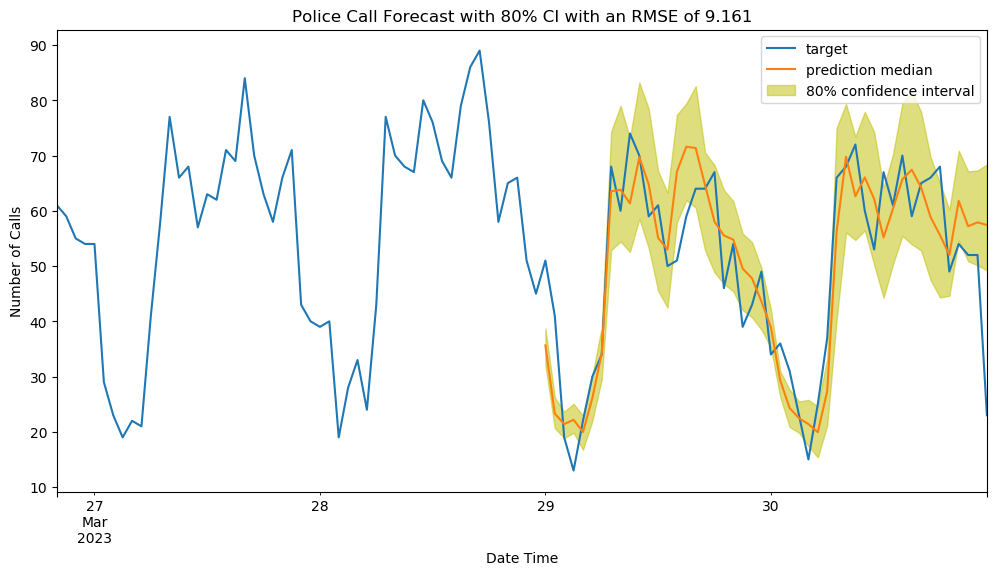

In [101]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-100:].plot(label="target")
    #actual_data[-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.title("Police Call Forecast with 80% CI with an RMSE of "+ str(RMSE))
    plt.ylabel('Number of Calls')
    plt.xlabel('Date Time')
    plt.show()

In [103]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: forecasting-deepar-230407-0259-019-666e1311


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:109424293498:endpoint/forecasting-deepar-230407-0259-019-666e1311".